# Softmax 回归

从零开始写 softmax 回归

softmax 回归其实是分类不是回归

softmax 回归的步骤：

- 初始 样本 与 样本标号
- 将样本分割成 训练集 和 测试集
- 初始化 矩阵 W 和 向量 b（线性回归 Y = W * X + b）
- 线性回归的结果过 softmax
- 定义 loss function，在这里是 交叉熵
- 定义优化器，做反向传播，更新参数
- 计算分类精度

重要构件：

- 线性回归
- softmax 算子
- loss 函数
- 优化器

In [1]:
import random
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
from IPython import display
import torch

## 1. 生成 样本 和 样本标号

生成 `clustr_num` 个簇，每个簇有 `sample_num` 个样本

In [2]:
# 画图参数
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
MARKERS = ['o', 'v', '^', 's', 'P']

# 业务参数
DIM = 3
CLUSTR_NUM = 10


def generate_sample(clustr_num, width=30, std=3, smin=600, smax=700, gen_seed=9603602):
    """
    clustr_num: 簇数
    width: 空间点位于长宽高均为 width 的正方体内
    std: 生成样本时，样本与样本中心距离的标准差
    smin: 生成样本量时，样本量的最小值
    smax: 生成样本量时，样本量的最大值
    """
    if clustr_num > len(COLORS) * len(MARKERS):
        raise Exception("Error: clustr_num <= len(COLORS) * len(MARKERS)")
    dim = DIM
    res = collections.defaultdict(list)
    
    random.seed(gen_seed)
    for i in range(clustr_num):
        mean = [random.random() * width for _ in range(dim)]
        sample_num = round((smax - smin) * random.random()) + smin
        for r in np.random.normal(0, std, sample_num):
            deg = [random.random() * math.pi * 2 for _ in range(2)]
            node = [mean[0] + r * math.cos(deg[0]) * math.cos(deg[1]),
                    mean[1] + r * math.cos(deg[0]) * math.sin(deg[1]),
                    mean[2] + r * math.sin(deg[0])]
        
            res[i].append(node)

    return res

In [3]:
samples = dict(generate_sample(clustr_num=CLUSTR_NUM))
# samples

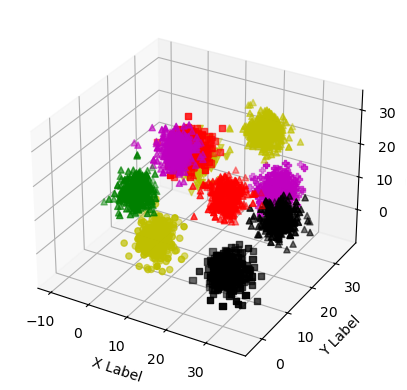

In [4]:
def _3d_plot(samples):
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    mix = [(c, m) for c in COLORS for m in MARKERS]
    np.random.seed(19680801)
    np.random.shuffle(mix)
    for i, f in enumerate(samples.items()):
        _, v = f
        color, marker = mix[i]

        xs = [e[0] for e in v]
        ys = [e[1] for e in v]
        zs = [e[2] for e in v]
        ax.scatter(xs, ys, zs, color=color, marker=marker)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
_3d_plot(samples)

## 2. 分割 训练集 和 测试集

将样本字典整成元组并打乱，分成训练集和测试集

In [5]:
def load_sample(train_rate=0.8):
    sample_list = []
    for k, v in samples.items():
        for s in v:
            e = (s, k)
            sample_list.append(e)
    
    random.shuffle(sample_list)
    train_num = math.floor(len(sample_list) * train_rate)
    
    train = sample_list[:train_num]
    test = sample_list[train_num:]

    return train, test

In [6]:
train_data, test_data = load_sample()
# train_data, test_data

In [7]:
len(train_data), len(test_data)

(5174, 1294)

## 3. 初始化模型参数

In [8]:
nums_input = DIM  # 输入数据的维度
nums_output = CLUSTR_NUM  # CLUSTR_NUM 是簇数，也是标签数

W = torch.normal(0, 0.01, size=(nums_input, nums_output), requires_grad=True, dtype=torch.float64)
b = torch.zeros(nums_output, requires_grad=True, dtype=torch.float64)

In [9]:
# W, b

In [10]:
print("W.shape:", W.shape)
print("b.shape:", b.shape)
print("W.dtype:", W.dtype)
print("b.dtype:", b.dtype)

W.shape: torch.Size([3, 10])
b.shape: torch.Size([10])
W.dtype: torch.float64
b.dtype: torch.float64


## 4. 定义 softmax 操作 

经过 softmax 操作，每个元素变成非负数，且每行总和为 1

你可以说 softmax 操作是在做标准化

但我觉得 softmax 操作更像是把原始数据做变换后，往概率那边硬凑

In [11]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 利用了广播机制

## 6. 定义 网络模型

In [12]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 7. 定义 损失函数

把 交叉熵函数 作为 损失函数

注意作为输入的 y_hat 和 y 的形状不同，本质上不是一个东西。它俩的关系是：

$y = j = argmax \hat y_{j}$

In [13]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

## 8. 优化器

`sgd()` 函数是：小批量随机梯度下降

参见：https://zh-v2.d2l.ai/chapter_linear-networks/linear-regression-scratch.html#sec-linear-scratch

In [14]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent.

    Defined in :numref:`sec_utils`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [15]:
def sgd_updater(batch_size, lr=0.1):
    """优化器
    batch_size: 批量大小
    lr: 学习率
    """
    return sgd([W, b], lr, batch_size)

## 9. 两个工具类

本节有两个工具类：

- 累加器
- 训练图作图器

In [16]:
# 累加器
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
# 训练图作图器
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def use_svg_display():
        """Use the svg format to display a plot in Jupyter.

        Defined in :numref:`sec_calculus`"""
        from matplotlib_inline import backend_inline
        backend_inline.set_matplotlib_formats('svg')

    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib.

        Defined in :numref:`sec_calculus`"""
        axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
        axes.set_xscale(xscale), axes.set_yscale(yscale)
        axes.set_xlim(xlim),     axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 10. 计算 分类精度

计算预测正确的数量：

In [18]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

计算预测正确的比例：

In [19]:
def cal_accuracy_rate(y_hat, y):
    """计算预测正确的比例"""
    return accuracy(y_hat, y) / len(y)

一个复合函数，用于计算 在指定数据集 上，网络 net 的精度

In [20]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 11. 数据迭代器

我的野生实现，不是官方的实现方法

每 `batch_size` 行输入 concat 在一起，对应的 `y` 也 concat 在一起

In [21]:
def data_iter(data, batch_size):
    """将 原始输入向量 拼接成 批量矩阵"""
    res = []
    batch_num = math.floor(len(data) / batch_size)
    for i in range(batch_num):
        start, end = batch_size * i, batch_size * (i + 1)
        X = torch.tensor([[e[0]] for e in data[start:end]])
        y = torch.tensor([e[1] for e in data[start:end]])
        res.append((X, y))
    return res

## 12. 训练

注意，学习率 lr 和 迭代周期数 num_epochs 都是可调的超参数

In [22]:
# 单批量训练
def train_epoch(train_data, net, loss, updater):
    metric = Accumulator(3)  # 用于存储 (训练损失总和、训练准确度总和、样本数)
    for X, y in train_data:
        # print(X, y)
        # 正向传播
        y_hat = net(X)
        
        # 计算梯度
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 反向传播
            l.sum().backward()

            # 使用优化器，更新参数
            updater(X.shape[0])  # X.shape[0] 是批量大小 (batch_size)
        
        # 记录当前状态
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    # print(metric[:], )
    return metric[0] / metric[2],  metric[1] / metric[2]

In [23]:
# 多批量训练
def train(num_epochs, net, train_data, test_data, loss, updater):
    """
    num_epochs: 迭代周期个数
    net: 网络模型函数
    train_data: 训练集
    test_data: 测试集
    loss: 损失函数
    updater: 优化器
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    
    batch_num = math.floor(len(train_data) / num_epochs)
    for epoch in range(num_epochs):
        start, end = batch_num * epoch, batch_num * (epoch + 1)
        train_metrics = train_epoch(train_data[start:end], net, loss, updater)
        test_acc = evaluate_accuracy(net, test_data)
        animator.add(epoch + 1, train_metrics + (test_acc,))  # train_metrics + (test_acc,) 是有三个元素的元组
    train_loss, train_acc = train_metrics
    assert train_loss < 20, train_loss
    assert train_acc <= 1 and train_acc > 0.5, train_acc
    assert test_acc <= 1 and test_acc > 0.5, test_acc
    print("train_loss:", round(train_loss, 5))
    print("train_acc:", round(train_acc, 5))
    print("test_acc:", round(test_acc, 5))

In [24]:
batch_size = 30  # 输入 X 的 X.shape[0]
num_epochs = 20  # 迭代周期数

train_dt = data_iter(train_data, batch_size)
test_dt = data_iter(test_data, batch_size)
len(train_dt), len(test_dt)

(172, 43)

train_loss: 3.55303
train_acc: 0.80417
test_acc: 0.77209


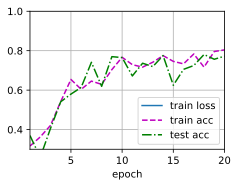

In [25]:
loss = cross_entropy
updater=torch.optim.SGD([W, b], lr=0.1, momentum=0.9)

train(num_epochs, net, train_dt, test_dt, loss, updater)

## 13. 预测

In [26]:
def predict(net, test_data, n=6):
    """预测标签"""
    for X, y in test_data:
        break
    trues = y
    preds = net(X).argmax(axis=1)
    
    indexs = list(range(len(trues)))
    random.shuffle(indexs)
    for i in indexs[:n]:
        print("true:", y[i])
        print("pred:", preds[i])
        print("=" * 15)

In [27]:
predict(net, test_dt, n=5)

true: tensor(1)
pred: tensor(6)
true: tensor(6)
pred: tensor(6)
true: tensor(2)
pred: tensor(2)
true: tensor(8)
pred: tensor(8)
true: tensor(5)
pred: tensor(3)


## 14. 背景知识

### 1）`tensor.numel`

`tensor.numel()` 函数的作用是返回张量中所有元素的总数

参见：https://pytorch.org/docs/stable/generated/torch.numel.html#torch.numel

下面是两个例子：

In [28]:
torch.tensor([e for e in range(80)]).numel()

80

In [29]:
torch.tensor([[1, 2, 3] for _ in range(80)]).numel()

240

### 2）元组 concat 可以通过以下语法实现

In [30]:
(1, 2) + (3,)

(1, 2, 3)

### 3）Ipython 的魔法

在函数后面加两个问号再运行会弹出函数详情信息

In [31]:
# from d2l import torch as d2l
# d2l.use_svg_display??

In [32]:
# from d2l import torch as d2l
# d2l.plt.subplots??

### 4）必须满足断言的条件，否则会抛出错误

In [33]:
# a = 0.4
# assert a < 0.5, a

In [34]:
# a = 0.6
# assert a < 0.5, a